In [133]:
import pandas as pd
import wordcloud
import numpy as np
import seaborn as sn
import string
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import word_tokenize
import pickle

In [134]:
pd.set_option('display.max_colwidth', None)

In [135]:
DATA_PATH="/Users/jyotsana.j/lithium/checkouts/dataset/"
allcolumns = ["id","labels","text","augmented_text_fr","augmented_text_es","augmented_text_jp","sentiment"]
columns = ['id', 'labels', 'text']

In [136]:
nps_aug = pd.read_csv(DATA_PATH + "Augmented_data.csv",usecols=allcolumns)
nps_aug.shape

(1298, 7)

In [137]:
tag_columns = ['labels','text']
nps_org_1 = pd.read_csv(DATA_PATH + "Original_dataset.csv",usecols=tag_columns)
nps_org= nps_org_1.dropna()
nps_org.shape

(472, 2)

In [138]:
negative =['WeakNoStrategy','SlowResponse/ResTime_Bugs','WeakCommunication','WeakSupport','WeakTeamKnowledge','WeakProdDesign_Analytics',
           'WeakProdDesign_Customization','WeakProdDesign_Features','WeakProdDesign_General','WeakProdDesign_Performance',
           'WeakProdDesign_Quality','WeakProdDesign_Security','WeakProdDesign_Stability','WeakRelationship','WeakProfessionalServices',
           'SlowProjectTimeline','Other_MarketingIncident','Other_Negative','Other_PriceTooHigh','ProductDesign']
positive = ['GoodStrategy','FastResponseTime','GoodCommunication','GoodSupport','StrongTeamKnowledge','GoodProductDesign',
            'StrongRelationship','Other_Positive']

In [139]:
def get_sentiment_Aug (row):
    sentiment=0
    row['labels']=row['labels'].replace("[","").replace("]","").replace("'","")
    for ele in row['labels'].split(","):
        if ele.strip() in positive:
            sentiment +=1
        elif ele.strip() in negative: 
            sentiment -=1
        elif ele.strip() in neutral:
            sentiment +=0 
    if sentiment <= 0:
        return 1
    else:
        return 0

In [140]:
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.stem import SnowballStemmer
import re
import nltk


lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
STOPWORDS = set(stopwords.words('english'))
snowball_stemmer = SnowballStemmer('english')
    
def toLower(text):
    return [sentence.lower() for sentence in text]

def remove_specialChar(text):
    return [sentence.replace(punctuation,' ') for sentence in text ]

def lemmatize_words(text):
    fullList=[]
    for sentence in text:
        pos_tagged_text = nltk.pos_tag(sentence.split())
        sentence = " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])
        fullList.append(sentence)
    return fullList

def strip_digits(text):
    fullList=[]
    for sentence in text:
        sentence = " ".join([word for word in str(sentence).split() if not word.isdigit()])
        fullList.append(sentence)
    return fullList

def strip_punctuation(text):
    fullList=[]
    for sentence in text:
        sentence = " ".join([word for word in str(sentence).split() if word not in punctuation])
        fullList.append(sentence)
    return fullList

def preprocessingText(textSet):
    textSet = textSet.dropna()
    textSet['text']=toLower(textSet['text']).copy()
    textSet['text']=lemmatize_words(textSet['text']).copy()
    textSet['text']=strip_digits(textSet['text'])
    textSet['text']=strip_punctuation(textSet['text']).copy()
    textSet = textSet.dropna()
    return textSet

Union of all augmented data

In [141]:
nps_org_data1=nps_aug[['id','labels','text','sentiment']]
nps_org_data2=nps_aug[['id','labels','augmented_text_fr','sentiment']]
nps_org_data2=nps_org_data2.rename(columns={'augmented_text_fr':'text'})
nps_org_data3=nps_aug[['id','labels','augmented_text_es','sentiment']]
nps_org_data3=nps_org_data3.rename(columns={'augmented_text_es':'text'})
nps_org_data4=nps_aug[['id','labels','augmented_text_jp','sentiment']]
nps_org_data4=nps_org_data4.rename(columns={'augmented_text_jp':'text'})
nps_org_data5=pd.concat([nps_org_data1, nps_org_data2, nps_org_data3, nps_org_data4], ignore_index=True)
nps_org_data=nps_org_data5.dropna()
nps_org_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5190 entries, 0 to 5191
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         5190 non-null   int64 
 1   labels     5190 non-null   object
 2   text       5190 non-null   object
 3   sentiment  5190 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 202.7+ KB


In [142]:
nps_org_data['sentiment'].value_counts()

1    3868
0    1322
Name: sentiment, dtype: int64

In [143]:
nps_org_data['derivedSentiment']=nps_org_data.apply(lambda row: get_sentiment_Aug(row), axis=1)
nps_org_data['derivedSentiment'].value_counts()

/Users/jyotsana.j/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1    4318
0     872
Name: derivedSentiment, dtype: int64

Sentiment and DerivedSentiment difference

In [144]:
nps_org_data_temp=nps_org_data[(nps_org_data.sentiment != nps_org_data.derivedSentiment)]
nps_org_data_temp.shape

(450, 5)

In [145]:
nps_org['sentiment']=nps_org.apply(lambda row: get_sentiment_Aug(row), axis=1)
nps_org['sentiment'].value_counts()

/Users/jyotsana.j/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1    394
0     78
Name: sentiment, dtype: int64

In [146]:
nps_all=pd.concat([nps_org_data, nps_org], ignore_index=True)
nps_all.shape

(5662, 5)

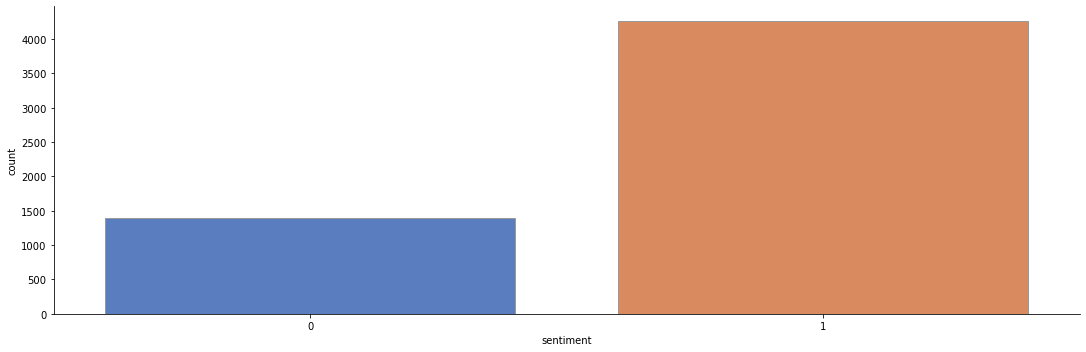

In [147]:
sn.catplot(x="sentiment", kind="count",palette="muted", edgecolor=".6",data=nps_all,height=5,aspect=3)

In [148]:
df=preprocessingText(nps_all)

/Users/jyotsana.j/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jyotsana.j/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jyotsana.j/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [149]:
vecCount = CountVectorizer(min_df=0.0,max_df=0.99,ngram_range=(1,3))
featuresCount = vecCount.fit(df['text'])
pickle.dump(featuresCount,open('countvecnps.pkl','wb'))

In [150]:
y = df['sentiment']
x_vec_train, x_vec_test, y_trainset, y_testset = train_test_split(df['text'],y,stratify=y, test_size=0.3, random_state=0)

In [151]:
x_trainset=featuresCount.transform(x_vec_train)
x_testset=featuresCount.transform(x_vec_test)

In [152]:
x_trainset.shape

(3633, 45999)

In [153]:
y_testset.shape

(1557,)

In [154]:
from sklearn.model_selection import cross_val_predict
def crossValidatorFunction(model):
    kf = StratifiedKFold(n_splits=10, shuffle = True, random_state=42)
    model.fit(x_trainset,y_trainset)
    y_model_train_pred = cross_val_predict(model, x_trainset, y_trainset, cv=kf)
    print("F1 Score train: ",f1_score(y_trainset, y_model_train_pred))
    y_model_test_pred = model.predict(x_testset)
    print("F1 Score test: ",f1_score(y_testset, y_model_test_pred))

## LOGISTIC REGRESSION

In [155]:
kf = StratifiedKFold(n_splits=10, shuffle = True, random_state=42)
clf = LogisticRegression(solver='liblinear',penalty='l2',C=1.0,multi_class='auto')
clf.fit(x_trainset,y_trainset)
y_clf_train_pred = cross_val_predict(clf, x_trainset, y_trainset, cv=kf)
print("LogisticReg F1 Score train: ",f1_score(y_trainset, y_clf_train_pred))

y_clf_test_pred = clf.predict(x_testset)
print("LogisticReg F1 Score test: ",f1_score(y_testset, y_clf_test_pred))
pickle.dump(clf,open('LogisticReg_new.pkl','wb'))

LogisticReg F1 Score train:  0.9632312986777758
LogisticReg F1 Score test:  0.9696202531645569


In [156]:
x_test=pd.DataFrame(x_vec_test)
x_test1=pd.DataFrame(y_testset)
x_test3=pd.concat([x_test, x_test1], ignore_index=True,axis=1)
x_test4=x_test3.rename(columns={0:'text',1:'sentiment'})
x_test4

,text,sentiment
3007,trust,0
4936,rug and be slow,1
3031,so we ask for a list of page google be crawl and tell u to go look at the statistic ... :( what we suspect be that not even know.,1
1976,"platform, it do not work",1
3322,interface clumsy.,1
...,...,...
1366,good communication,0
1326,our tam receive our call for two week and just read our portal event ticket for u,1
1247,intermittent glitch,1
2679,"i can send email to our account team, nothing be answered. concern about the stability of the platform.",1


In [157]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss
def evaluate_on_test(predictor, test_data, th=0.4):
    
    pred = predictor.predict_proba(x_vec_test.text.tolist())
    pred_th = (pred >= th).astype(int)
    
    test_labels = x_vec_test[labels_df.columns.tolist()].values
    
    
    model_scores = {}
    macro_f1 = f1_score(test_labels, pred_th, average='macro')
    micro_f1 = f1_score(test_labels, pred_th, average='micro')
    ham_loss = hamming_loss(test_labels, pred_th)
    accuracy = accuracy_score(test_labels, pred_th)
    model_scores["micro_f1"] = micro_f1
    model_scores["ham_loss"] = ham_loss
    model_scores["accuracy"] = accuracy
    
    return model_scores

## FAST TEXT

In [158]:
def createDataForFastText(file,dataframe):
    f= open(file,"w+")
    for ind in dataframe.index:
        if (dataframe['sentiment'][ind] == 1.0):
            f.write("__label__1 %s \n" % dataframe['text'][ind])
        else:
            f.write("__label__0 %s \n" % dataframe['text'][ind])

In [159]:
train=pd.DataFrame(x_vec_train)
train['sentiment']=y_trainset
test=pd.DataFrame(x_vec_test)
test['sentiment']=y_testset
createDataForFastText("nps.valid",test)
createDataForFastText("nps.train",train)

In [160]:
import fasttext
fasttext = fasttext.train_supervised(input="nps.train", epoch=200,lr=0.1,wordNgrams=2,loss='ova')
fasttext.test("nps.train")

(3633, 0.9958711808422791, 0.9958711808422791)

In [161]:
result = fasttext.test("nps.valid")

In [162]:
#F1 = 2 * (precision * recall) / (precision + recall)
f1_score = 2*(result[1]*result[2])/(result[1]+result[2])
print("FastText F1 Score test: ",f1_score)

FastText F1 Score test:  0.9710982658959537


In [163]:
fasttext.save_model("fastText_nps.bin")

## 2019 statements

In [ ]:
nps_2019 = pd.read_csv(DATA_PATH + "Tagging_2019.csv",usecols=["Rel-NPS-Feedback","Sentiment - Overall"])
nps_2019=nps_2019.rename(columns={'Sentiment - Overall':'labels','Rel-NPS-Feedback':'text'})
nps_2019_1=nps_2019.dropna()
nps_2019_1.shape

In [ ]:
nps_2019_1['sentiment']=nps_2019_1.apply(lambda row: get_sentiment_Aug(row), axis=1)
nps_2019_1['sentiment'].value_counts()

In [ ]:
df=preprocessingText(nps_2019_1)

In [ ]:
x_testset=featuresCount.transform(df['text'])
y_testset=df['sentiment']

In [ ]:
y_clf_test_pred = clf.predict(x_testset)
print("LogisticReg F1 Score test: ",f1_score(y_testset, y_clf_test_pred))

## Predict

In [ ]:
fasttext.predict("bad support", k=-1)

In [ ]:
tt=featuresCount.transform(["bad support"])
clf.predict(tt)